In [4]:
import re
from glob import iglob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from hurry.filesize import size
import seaborn as sns


def split_on_slash(df_col, split_index):
    return df_col.apply(lambda x: x.split(" / ")[split_index])

def get_only_characters(string):
    return re.sub(r'[^a-zA-Z]+', '', string)

def get_only_numbers(string):
    return float(re.sub(r'[^\d\.]', '', string))

def to_bit(value):
    return int({
        "b": get_only_numbers(value) * 1,
        "kib": get_only_numbers(value) * 10e3,
        "kb": get_only_numbers(value) * 10e3,
        "mib": get_only_numbers(value) * 10e6,
        "mb": get_only_numbers(value) * 10e6,
        "gib": get_only_numbers(value) * 10e9,
        "gb": get_only_numbers(value) * 10e9,
    }.get(get_only_characters(value).lower(), 0))
    
def percentage_to_float(df_col):
    return df_col.apply(lambda x: float(x[0:-1]))

In [5]:
dfs = {}
for fname in iglob('*.csv'):
    df = pd.read_csv(fname, delimiter=r'\s\s+', engine='python')

    df = df[df['NET I/O'] != 'NET I/O']

    df["mem_percentage"] = percentage_to_float(df["MEM %"])
    df["cpu_percentage"] = percentage_to_float(df["CPU %"])
    df["mem_usage_bits"] = df["MEM USAGE / LIMIT"].apply(lambda x: to_bit(x[:x.find('/')-1]))
    df[["net_input_bits", "net_output_bits"]] = df["NET I/O"].apply(lambda x: pd.Series(map(to_bit, map(str.strip, x.split('/')))))
    df = df.drop(["CONTAINER ID", "CPU %", "MEM USAGE / LIMIT", "MEM %", "NET I/O", "PIDS", "BLOCK I/O"], axis=1)    
    # groups = df.groupby('NAME')
    dfs[int(fname[5:fname.find('.')])] = df

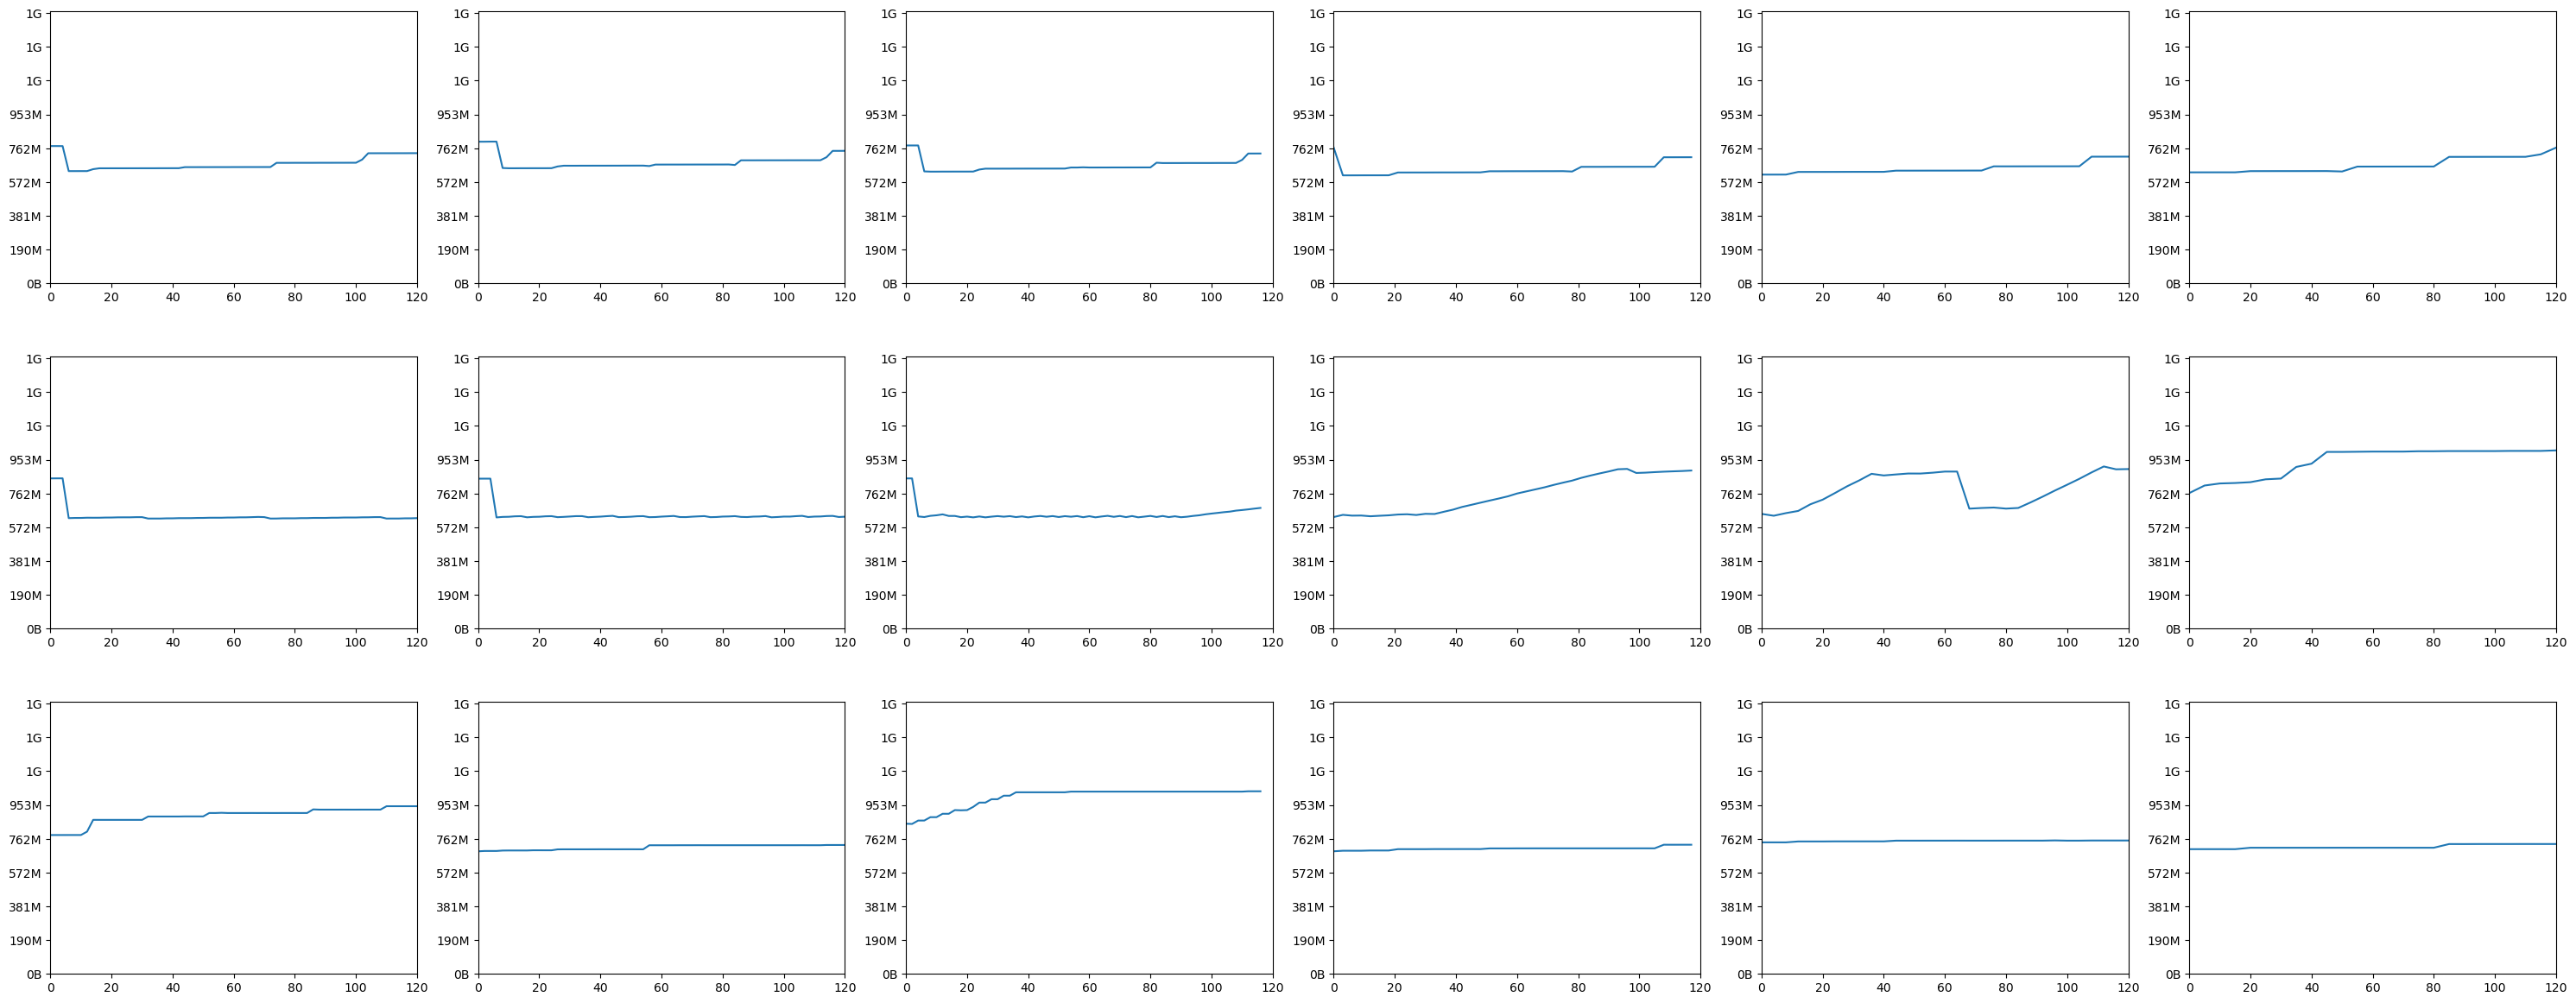

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(30, 12))
fig.tight_layout(pad=2, h_pad=4)

for i, container in enumerate(["edge_data_manager", "edge_broker", "case2-mongodb-1"]):
    for j, replicas_amount in enumerate(sorted(dfs.keys())):
        df = dfs[replicas_amount]

        edm = df.loc[df["NAME"] == container].copy()
        edm['time'] = pd.timedelta_range(start='0 seconds', periods=len(edm), freq=f'{round(125 / len(edm))}S')
        edm.set_index("time", inplace=True)
        edm = edm.drop(["NAME"], axis=1)

        # edm.plot(ax=axes[i][j])
        # axes[i][j].set_ylim(right=0)
        axes[i][j].set_xlim(0, 120)
        axes[i][j].set_ylim(0, (1024**3)*1.5)
        axes[i][j].plot(edm.index.seconds, edm.mem_usage_bits)
        axes[i][j].yaxis.set_major_formatter(lambda x, pos: size(x))

        # axes[i][j].set_xlim(0, 1e10)

# plt.title('{replicas} clients')
# plt.xlabel('Seconds')
# plt.ylabel('Usage %')
# plt.tight_layout(pad=2, h_pad=4)
# plt.ylim(0, 10)

plt.show()


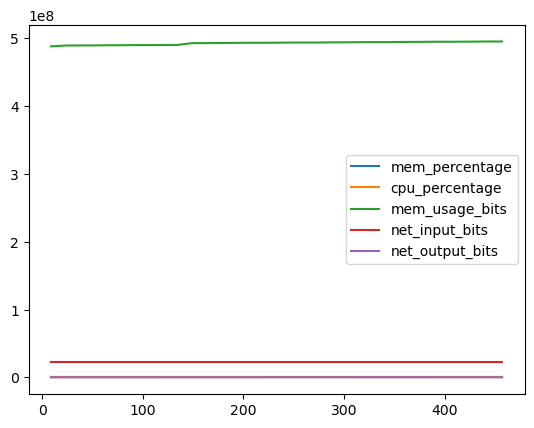

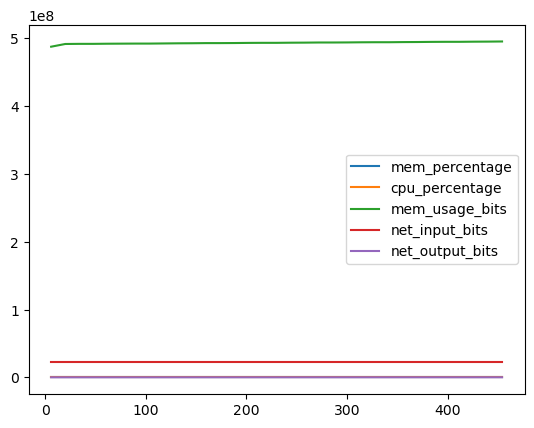

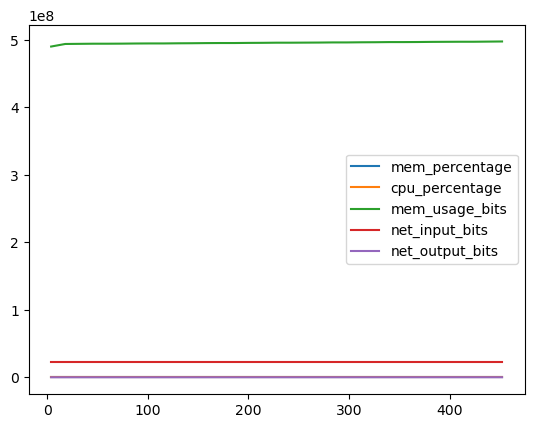

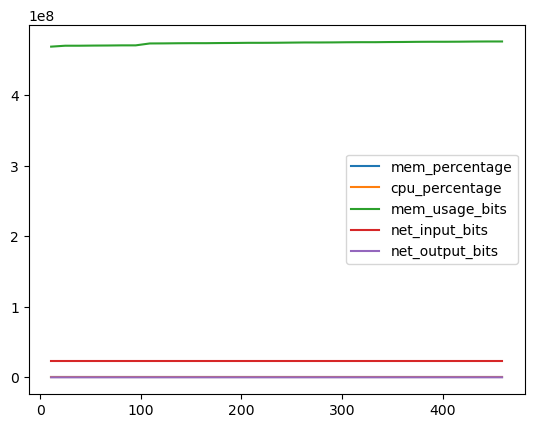

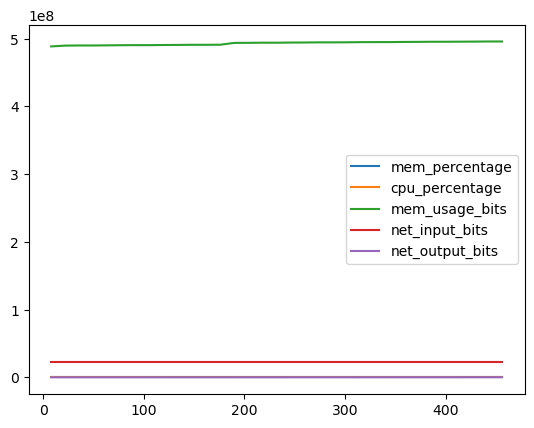

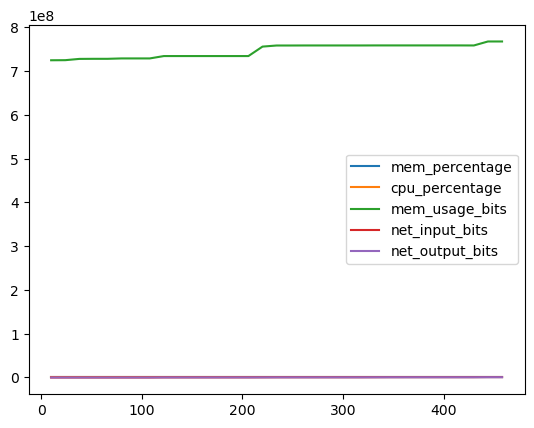

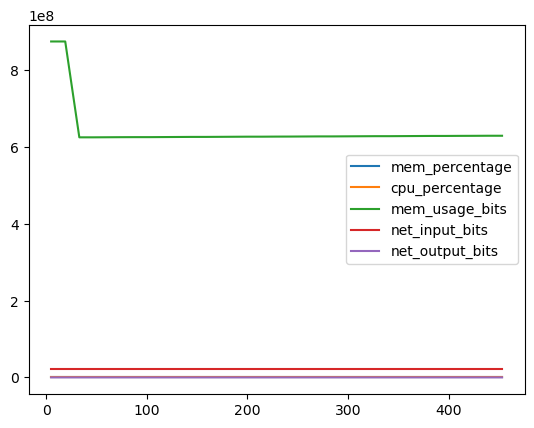

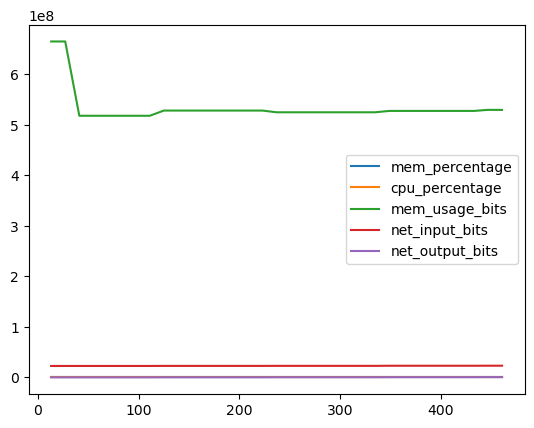

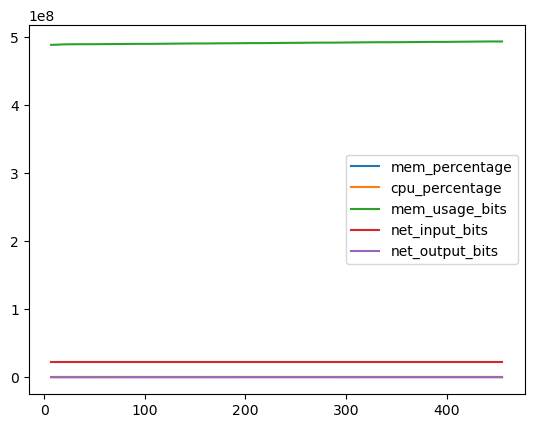

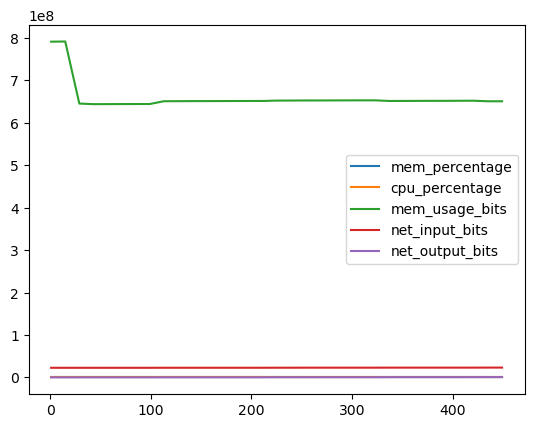

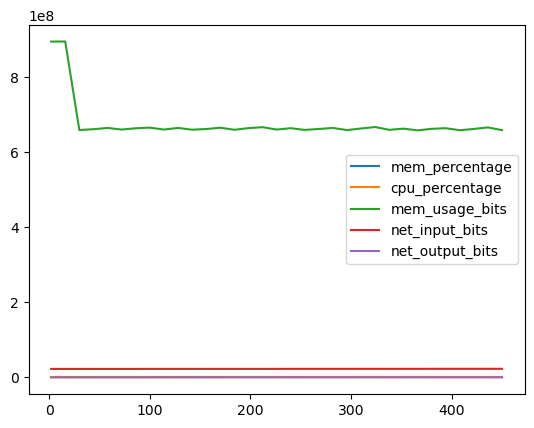

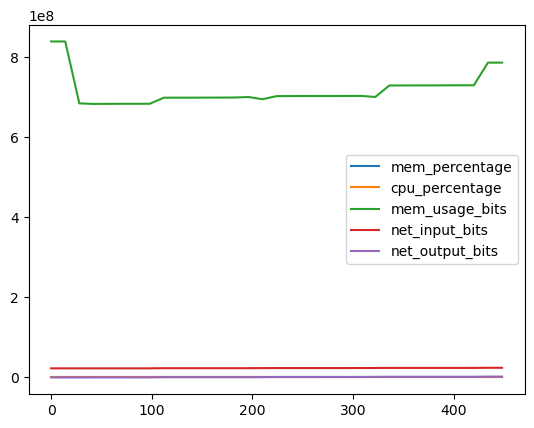

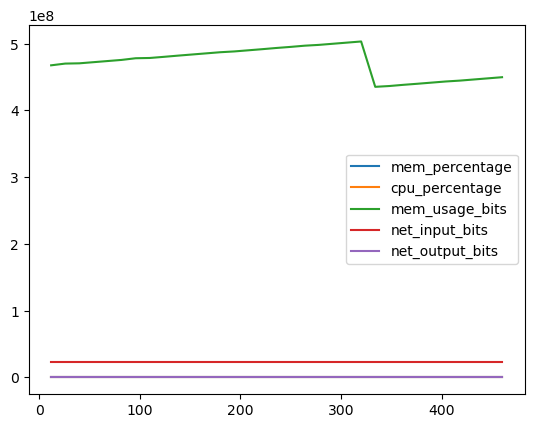

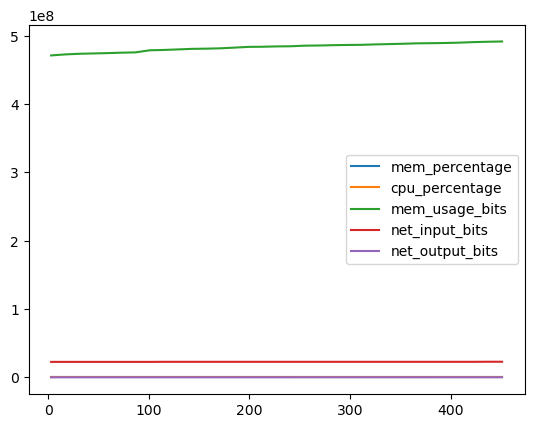

In [5]:
for client_replicas, df_g in dfs.items():
    df_g.plot()
    break

pandas.core.frame.DataFrame

In [25]:
df.index = pd.date_range(0, freq='S', periods=len(df))

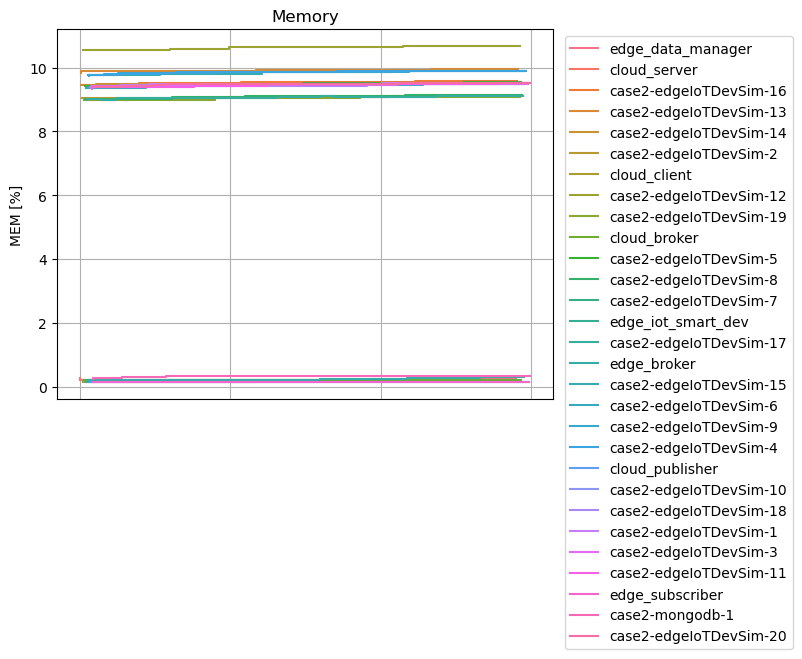

In [26]:
sns.lineplot(x=df.index, y="mem_percentage", hue="NAME", data=df, drawstyle="steps")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel("MEM [%]")
plt.title("Memory")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid()
plt.show()